In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt

from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor
from qwen_vl_utils import process_vision_info


In [2]:
import torch

print("🔧 Torch version:", torch.__version__)
print("💻 CUDA available:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("🚀 GPU name:", torch.cuda.get_device_name(0))
else:
    print("❌ GPU not detected. Running on CPU.")


🔧 Torch version: 2.5.1+cu121
💻 CUDA available: True
🚀 GPU name: NVIDIA GeForce RTX 4060 Laptop GPU


In [3]:
# === CONFIG ===
images_path = r"C:\Users\ASUS\Desktop\second_degree\final_project\dataset\images"
MAX_IMAGES = 50  # Limit to 50 images for now

# === LOAD IMAGES INTO MEMORY ===
image_files = sorted([
    file for file in os.listdir(images_path)
    if file.lower().endswith(('.jpg', '.jpeg', '.png'))
])[:MAX_IMAGES]

images = []
for file in image_files:
    img_path = os.path.join(images_path, file)
    img = Image.open(img_path).convert("RGB")
    images.append((file, img))

print(f"✅ Loaded {len(images)} images.")


✅ Loaded 0 images.


✅ Loaded 50 images.


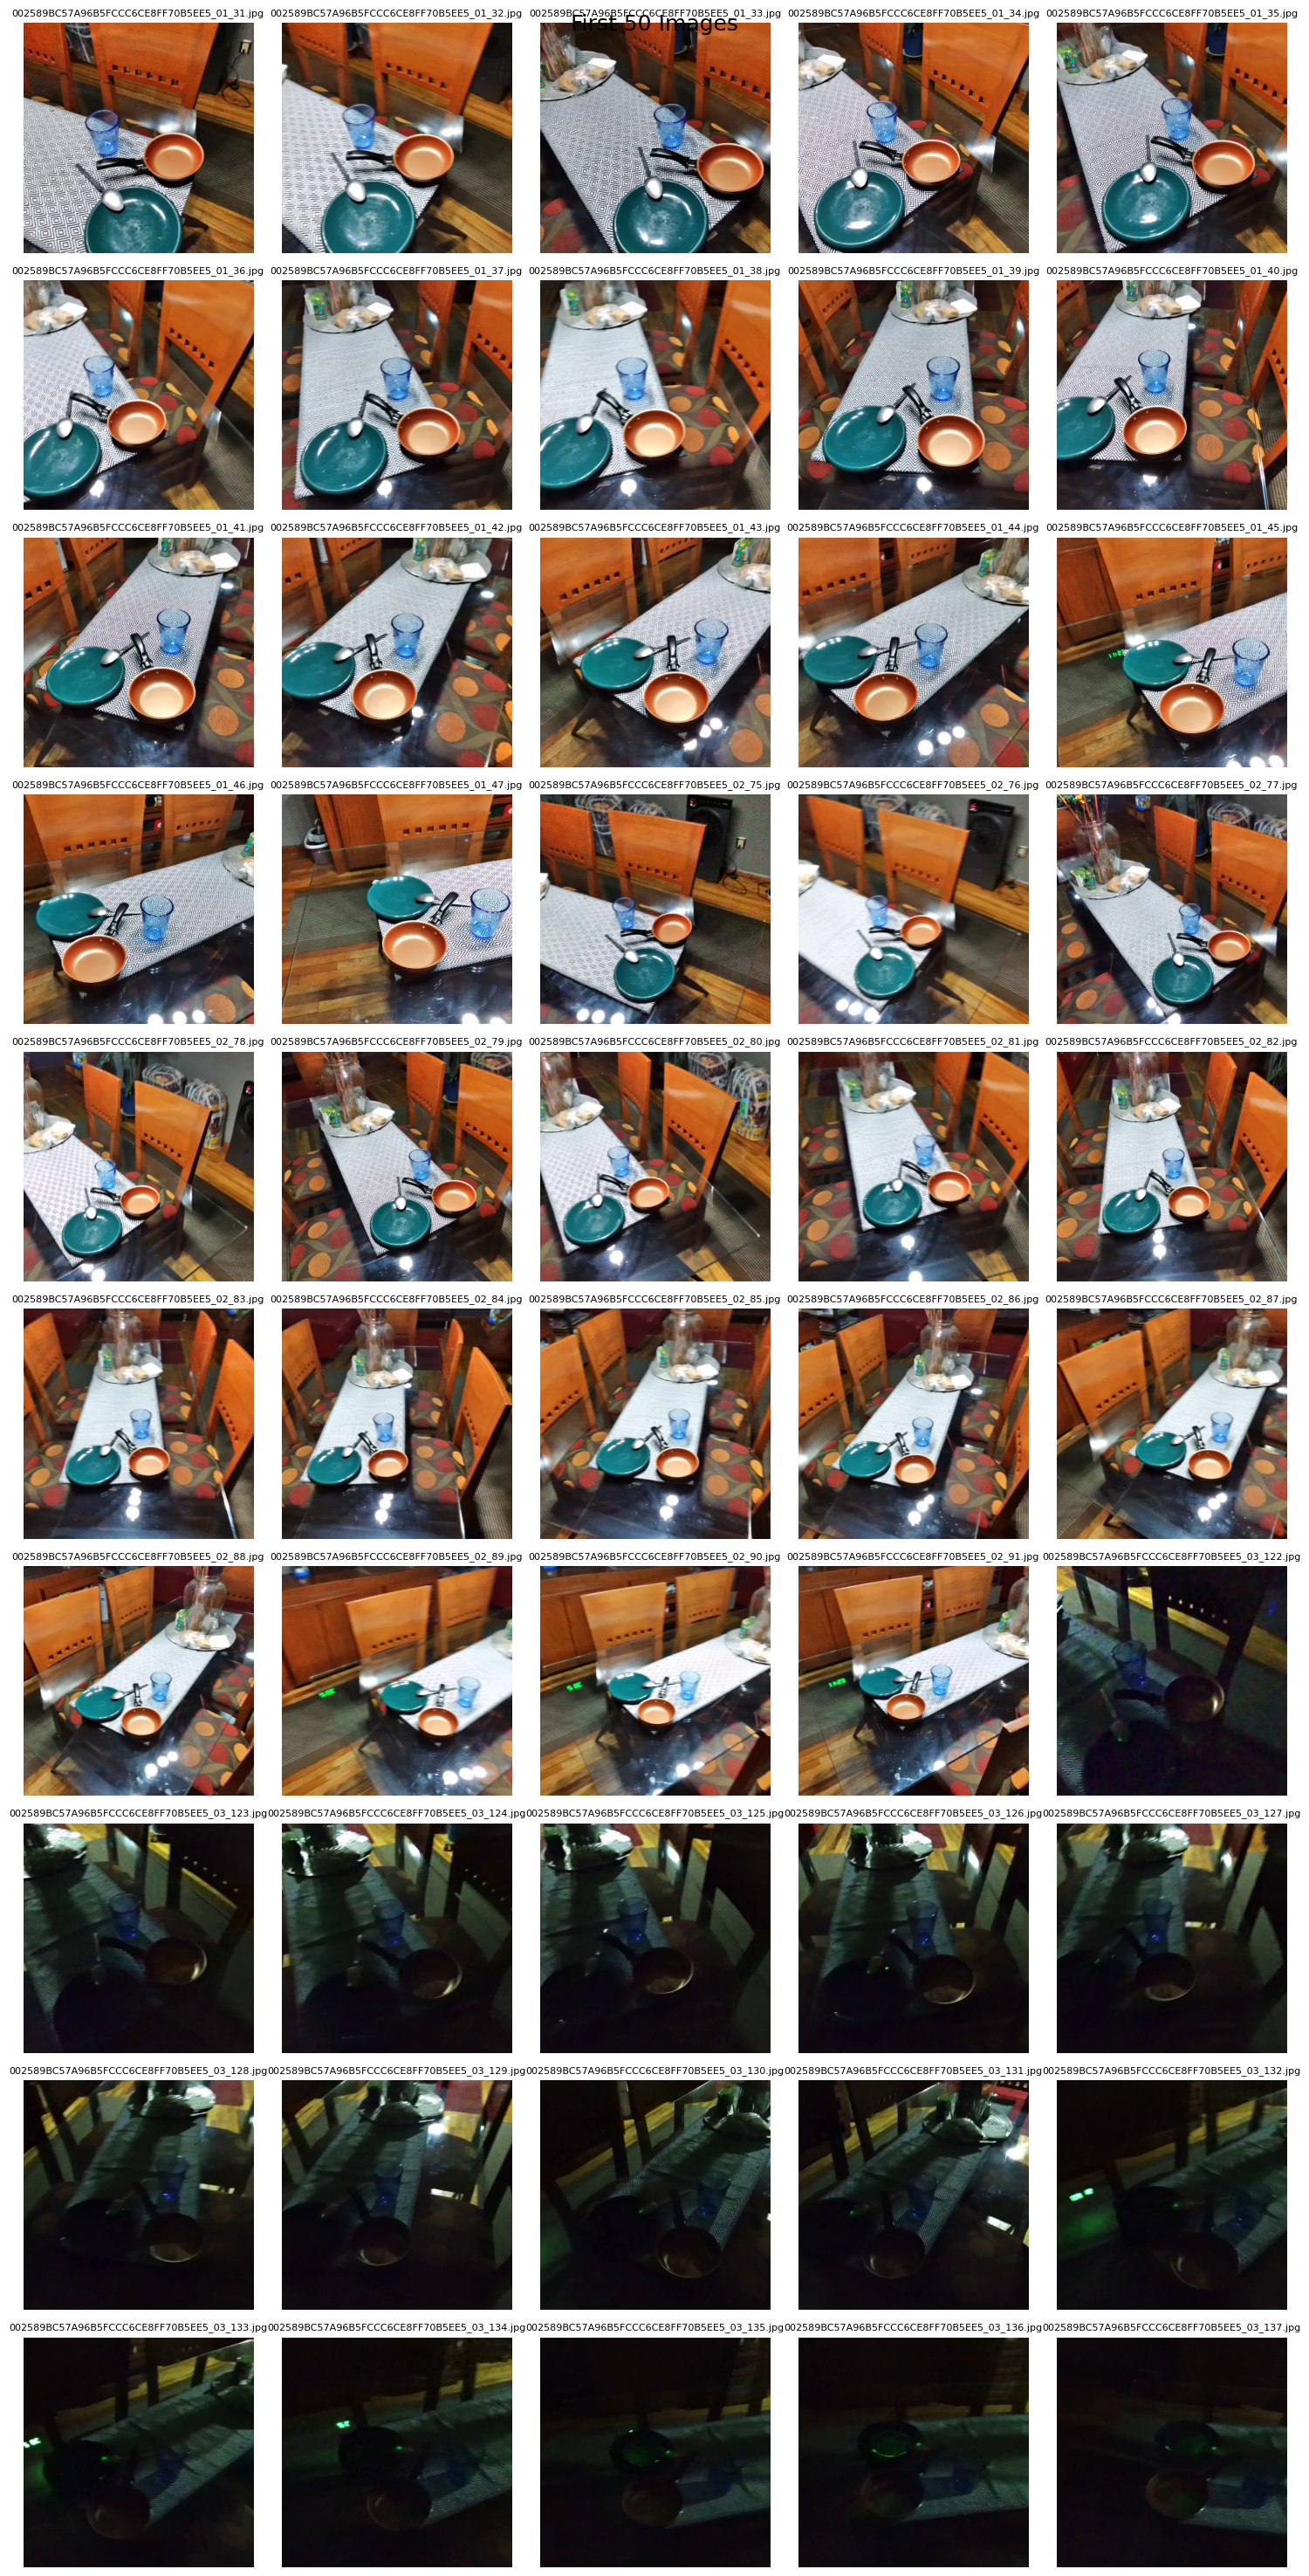

In [4]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# === CONFIG ===
images_path = r"C:\Users\ASUS\Desktop\second_degree\final_project\dataset\images"
MAX_IMAGES = 50

# === COLLECT IMAGES RECURSIVELY ===
image_files = []
for root, dirs, files in os.walk(images_path):
    for file in sorted(files):
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_files.append(os.path.join(root, file))
    if len(image_files) >= MAX_IMAGES:
        break

image_files = image_files[:MAX_IMAGES]

# === LOAD IMAGES ===
images = []
for file_path in image_files:
    try:
        img = Image.open(file_path).convert("RGB")
        images.append((os.path.basename(file_path), img))
    except Exception as e:
        print(f"❌ Could not load {file_path}: {e}")

print(f"✅ Loaded {len(images)} images.")

# === DISPLAY IMAGES IN A GRID ===
n_cols = 5
n_rows = (len(images) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 3))
fig.suptitle("First 50 Images", fontsize=18)

for i, ax in enumerate(axes.flat):
    if i < len(images):
        filename, img = images[i]
        ax.imshow(img)
        ax.set_title(filename, fontsize=8)
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()




In [5]:
processor = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-3B-Instruct")


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [5]:
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor
from qwen_vl_utils import process_vision_info

# === CONFIG ===
question = "What should I do to get to the door?"

# === LOAD MODEL ONLY ONCE ===
print("[INFO] Loading model...")
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2.5-VL-3B-Instruct", torch_dtype="auto", device_map="auto"
)
processor = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-3B-Instruct")

# === INFERENCE FROM EXISTING images LIST ===
for i, (filename, image) in enumerate(images, 1):
    print(f"\n[{i:02d}] Processing {filename}...")

    # Build message using in-memory image (no path needed)
    messages = [
        {
            "role": "user",
            "content": [
                {"type": "image", "image": image},
                {"type": "text", "text": question},
            ],
        }
    ]

    # Process the input
    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    image_inputs, video_inputs = process_vision_info(messages)

    inputs = processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt",
    ).to(model.device)

    # Generate output
    generated_ids = model.generate(**inputs, max_new_tokens=128)
    generated_ids_trimmed = [
        out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]
    output_text = processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )

    print(f"🔍 {filename} → {output_text[0]}")


[INFO] Loading model...


config.json:   0%|          | 0.00/1.37k [00:00<?, ?B/s]

c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ASUS\.cache\huggingface\hub\models--Qwen--Qwen2.5-VL-3B-Instruct. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors.index.json:   0%|          | 0.00/65.4k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model-00001-of-00002.safetensors:   0%|          | 0.00/3.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.53G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/216 [00:00<?, ?B/s]

Some parameters are on the meta device because they were offloaded to the cpu.
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.



[01] Processing 002589BC57A96B5FCCC6CE8FF70B5EE5_01_31.jpg...
🔍 002589BC57A96B5FCCC6CE8FF70B5EE5_01_31.jpg → To get to the door, you need to find and use the exit. In this image, there is an orange bowl on the table, which might be a clue or a way to move around the room. You could try picking up the bowl and using it as a stepping stone to reach the door. Alternatively, if there is a window or a door visible in the background, you can try to open it directly. If neither of these options works, you may need to look for other ways to navigate through the room to find the exit.

[02] Processing 002589BC57A96B5FCCC6CE8FF70B5EE5_01_32.jpg...
🔍 002589BC57A96B5FCCC6CE8FF70B5EE5_01_32.jpg → To get to the door, you need to move around the room and find the exit. Here are some steps you can follow:

1. **Look for the Door**: Check if there is a door in the room or nearby. It might be on the opposite side of the table or in another part of the room.

2. **Move Around**: If the door is not visib

In [6]:
from qwen_vl_utils import process_vision_info

question = "What should I do to get to the door?"

for i, (filename, image) in enumerate(images, 1):
    print(f"\n[{i:02d}] Processing {filename}...")

    messages = [{
        "role": "user",
        "content": [
            {"type": "image", "image": image},
            {"type": "text", "text": question},
        ],
    }]

    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    image_inputs, video_inputs = process_vision_info(messages)

    inputs = processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt"
    ).to(model.device)

    generated_ids = model.generate(**inputs, max_new_tokens=128)
    generated_ids_trimmed = [
        out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]
    output_text = processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )

    print(f"🔍 {filename} → {output_text[0]}")



[01] Processing 002589BC57A96B5FCCC6CE8FF70B5EE5_01_31.jpg...
🔍 002589BC57A96B5FCCC6CE8FF70B5EE5_01_31.jpg → To get to the door, you need to find and use the exit. In this image, there is an orange bowl on the table, which might be a clue or a distraction. You should look for a way out of the room, possibly through a window or another door. If you can't see any exits directly, you might need to move around the room to find one.

[02] Processing 002589BC57A96B5FCCC6CE8FF70B5EE5_01_32.jpg...
🔍 002589BC57A96B5FCCC6CE8FF70B5EE5_01_32.jpg → To get to the door, you need to move around the room and find the exit. Here are some steps you can follow:

1. **Look for the Door**: Check if there is a door in the room or nearby. It might be on the opposite side of the table or in another part of the room.

2. **Move Around**: If the door is not visible, try moving around the room to see if it appears from another angle.

3. **Use the Table**: If the door is behind the table, you might need to move 

In [7]:
from qwen_vl_utils import process_vision_info

# === QUESTION TO ASK ===
question = "What should I do to get to the door?"

# === RUN INFERENCE ON EACH IMAGE ===
for i, (filename, image) in enumerate(images, 1):
    print(f"\n[{i:02d}] Processing {filename}...")

    # Build structured input
    messages = [
        {
            "role": "user",
            "content": [
                {"type": "image", "image": image},
                {"type": "text", "text": question},
            ],
        }
    ]

    # Prepare model input
    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    image_inputs, video_inputs = process_vision_info(messages)

    inputs = processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt"
    ).to(model.device)

    # Generate prediction
    generated_ids = model.generate(**inputs, max_new_tokens=128)
    generated_ids_trimmed = [
        out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]
    output_text = processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )

    print(f"🔍 {filename} → {output_text[0]}")



[01] Processing 002589BC57A96B5FCCC6CE8FF70B5EE5_01_31.jpg...
🔍 002589BC57A96B5FCCC6CE8FF70B5EE5_01_31.jpg → To get to the door, you need to find and use the exit. In this image, there is an orange bowl on the table, which might be a clue or a way to move around the room. You could try picking up the bowl and using it as a stepping stone to reach the door. Alternatively, if there is a window or a door in the background, you can look for that to find the exit.

[02] Processing 002589BC57A96B5FCCC6CE8FF70B5EE5_01_32.jpg...
🔍 002589BC57A96B5FCCC6CE8FF70B5EE5_01_32.jpg → To get to the door, you need to move around the room and find the entrance. Here are some steps you can follow:

1. **Look for the Door**: Check if there is a door in the room or near it.
2. **Move Around**: If there is no door visible, try moving around the room to see if you can spot one from different angles.
3. **Use Furniture**: Sometimes doors are hidden behind furniture. Look behind chairs, tables, or other pieces 

In [6]:
import shutil
import os

cache_dir = os.path.expanduser("~/.cache/huggingface/hub/models--openbmb--MiniCPM-V-2")
if os.path.exists(cache_dir):
    shutil.rmtree(cache_dir)
    print("✅ המטמון נמחק בהצלחה.")
else:
    print("ℹ️ המטמון לא נמצא או כבר נמחק.")


✅ המטמון נמחק בהצלחה.


In [7]:
try:
    import sentencepiece
    print("✅ הספרייה 'sentencepiece' מותקנת כראוי.")
except ImportError:
    print("❌ הספרייה 'sentencepiece' לא מותקנת. נא להתקין באמצעות 'pip install sentencepiece'.")


✅ הספרייה 'sentencepiece' מותקנת כראוי.


In [8]:
import transformers
print(f"גרסת transformers: {transformers.__version__}")


גרסת transformers: 4.49.0


In [9]:
from configuration_minicpm import MiniCPMVConfig
from modeling_minicpm import MiniCPMForCausalLM, MiniCPMPreTrainedModel
from resampler import Resampler



In [10]:
import os
import torch
from PIL import Image
from transformers import AutoTokenizer
from modeling_minicpmv import MiniCPMV  # ✅ Custom model class defined locally

# === CONFIGURATION ===
images_path = r"C:\Users\ASUS\Desktop\second_degree\final_project\dataset\images"
question = "How should I get to the door? Give me directions like: 'go right twice, then left, then forward three steps, then backward.'"
sampling_interval = 40  # Sample one image every 40 frames

# === LOAD MODEL AND TOKENIZER ===
model = MiniCPMV.from_pretrained(
    'openbmb/MiniCPM-V-2',
    trust_remote_code=True,
    torch_dtype=torch.bfloat16
).to('cuda')

tokenizer = AutoTokenizer.from_pretrained(
    'openbmb/MiniCPM-V-2',
    trust_remote_code=True
)

model.eval()

# === COLLECT IMAGES FROM FOLDER ===
image_files = []
for root, _, files in os.walk(images_path):
    files = sorted([f for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    image_files.extend([os.path.join(root, files[i]) for i in range(0, len(files), sampling_interval)])

# === RUN INFERENCE ON EACH IMAGE ===
output_log = []
for i, image_path in enumerate(image_files, 1):
    try:
        print(f"[{i:02d}] Processing: {os.path.basename(image_path)}")
        image = Image.open(image_path).convert("RGB")

        # Construct the user prompt
        msgs = [{"role": "user", "content": question}]

        # Run the model's chat interface (official API)
        response, context, _ = model.chat(
            image=image,
            msgs=msgs,
            context=None,
            tokenizer=tokenizer,
            sampling=True,
            temperature=0.7,
            use_cache=False  # Disable cache to avoid DynamicCache issues
        )

        print(f"→ {response}")
        output_log.append(f"{os.path.basename(image_path)} → {response}")

    except Exception as e:
        print(f"⚠️ Inference failed on {os.path.basename(image_path)} – {type(e).__name__}: {e}")

# === SAVE RESULTS TO FILE ===
with open("minicpm_directions.txt", "w", encoding="utf-8") as f:
    f.write("\n".join(output_log))

print("\n✅ All predictions saved to 'minicpm_directions.txt'")





ImportError: cannot import name 'MiniCPMForCausalLM' from partially initialized module 'modeling_minicpmv' (most likely due to a circular import) (c:\Users\ASUS\Desktop\second_degree\final_project\dataset\images\modeling_minicpmv.py)